In [1]:
# STANDARD LIBRARIES
import os
import warnings
warnings.filterwarnings("ignore")

# THIRD PARTY LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pydataset

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing


# LOCAL LIBRARIES
import env
import acquire
import prepare

# ACQUIRE

In [2]:
# Acquire data from SQL using module found in acuire.py
df = acquire.get_zillow_data()

Reading from csv file...


In [3]:
df.head()

,bedrooms,bathrooms,square_feet,tax_value,year_built,tax_amount,geo_code,county_id
0,4.0,3.5,3100.0,1023282.0,1998.0,11013.72,6059.0,1286.0
1,2.0,1.0,1465.0,464000.0,1967.0,5672.48,6111.0,2061.0
2,3.0,2.0,1243.0,564778.0,1962.0,6488.30,6059.0,1286.0
3,4.0,3.0,2376.0,145143.0,1970.0,1777.51,6037.0,3101.0
4,4.0,3.0,2962.0,773303.0,1950.0,9516.26,6037.0,3101.0


In [4]:
# Obtain rows and column counts
df.shape

(52441, 8)

### Observations/Takeaways

# PREPARE

In [5]:
# acquire 'cleaned' data
df = prepare.wrangle_zillow(df)

In [6]:
df.head()

,bedrooms,bathrooms,square_feet,tax_value,year_built,tax_amount,geo_code,county_id
0,4.0,3.5,3100.0,1023282.0,1998,11013.72,6059.0,1286.0
1,2.0,1.0,1465.0,464000.0,1967,5672.48,6111.0,2061.0
2,3.0,2.0,1243.0,564778.0,1962,6488.30,6059.0,1286.0
3,4.0,3.0,2376.0,145143.0,1970,1777.51,6037.0,3101.0
4,4.0,3.0,2962.0,773303.0,1950,9516.26,6037.0,3101.0


In [7]:
# number of rows and columns after cleaning data
df.shape

(52315, 8)

In [8]:
# review data types and null values
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52315 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     52315 non-null  float64
 1   bathrooms    52315 non-null  float64
 2   square_feet  52315 non-null  float64
 3   tax_value    52315 non-null  float64
 4   year_built   52315 non-null  int64  
 5   tax_amount   52315 non-null  float64
 6   geo_code     52315 non-null  object 
 7   county_id    52315 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 3.6+ MB


In [9]:
# Observe descriptive stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,52315.0,3.305897,0.940601,0.00,3.000,3.00,4.00,14.0
bathrooms,52315.0,2.302791,1.019080,0.00,2.000,2.00,3.00,18.0
square_feet,52315.0,1922.553914,1003.629061,128.00,1268.000,1658.00,2305.00,21929.0
tax_value,52315.0,528044.818809,748457.587363,1000.00,193701.000,373374.00,618617.00,49061236.0
year_built,52315.0,1963.395699,23.133908,1878.00,1950.000,1961.00,1979.00,2016.0
tax_amount,52315.0,6434.748320,8709.643614,49.18,2656.185,4645.42,7371.64,586639.3
county_id,52315.0,2525.808372,803.739679,1286.00,1286.000,3101.00,3101.00,3101.0


#### Observations/Takeaways:

## Univariate Distributions

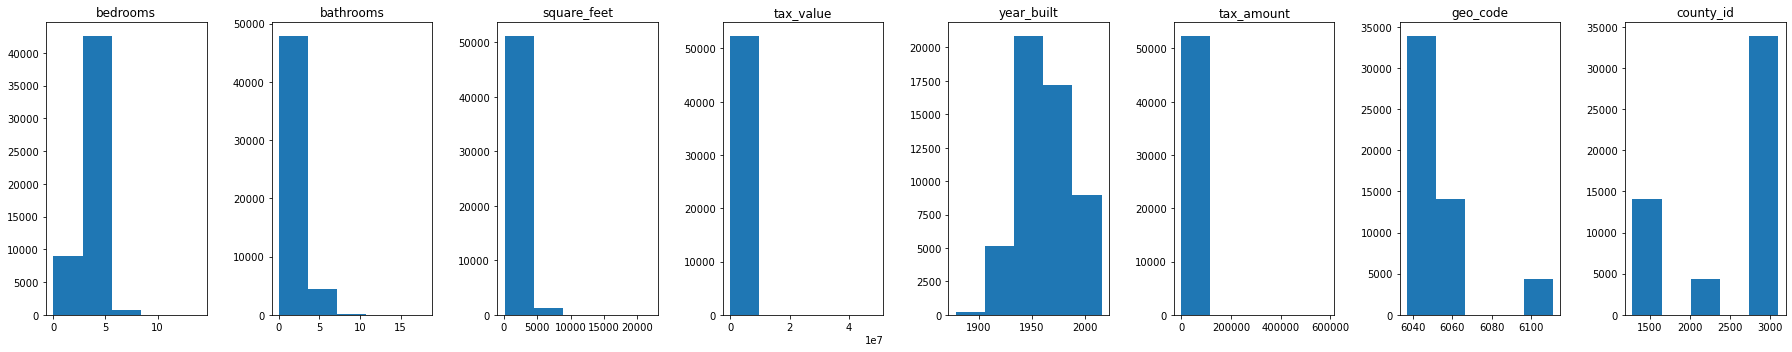

In [10]:
# list of numeric columns
cols = [col for col in df.columns if col not in ['fed_code']]

# figsize width to height
plt.figure(figsize=(25, 5))

# loop to iterate over columns
for i, col in enumerate(cols):
        
        # i starts at 0 but plot numbers should start at 1
        plot_number = i + 1
        
        # create subplot
        plt.subplot(1, len(cols), plot_number)
        
        # create title with the column name
        plt.title(col)
        
        # display a histogram for each of the columns            
        df[col].hist(bins=5)
        
        # Hide gridlines.
        plt.grid(False)
         
        # turn off scientific notation
        plt.ticklabel_format(useOffset=False)
    
plt.tight_layout()
plt.show()

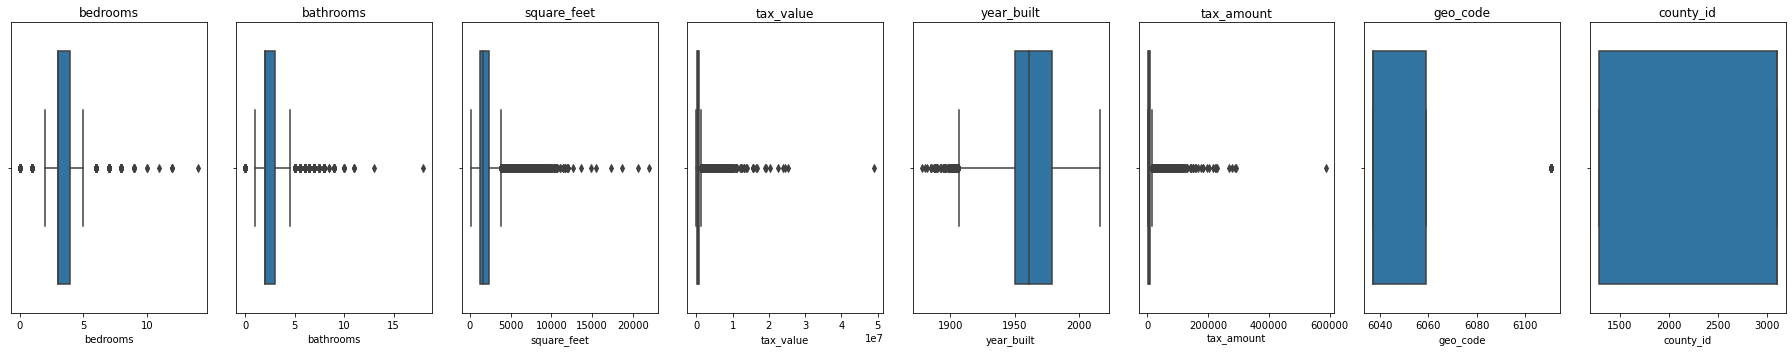

In [11]:
# Visualize Boxplot/Skew


# list of numeric columns
cols = [col for col in df.columns if col not in ['fed_code']]

# figsize width to height
plt.figure(figsize=(25, 5))

# loop to iterate over columns
for i, col in enumerate(cols):
        
        # i starts at 0 but plot numbers should start at 1
        plot_number = i + 1
        
        # create subplot
        plt.subplot(1, len(cols), plot_number)
        
        # create title with the column name
        plt.title(col)
        
        # display a histogram for each of the columns            
        sns.boxplot(df[col])
        
        # Hide gridlines.
        plt.grid(False)
         
      
    
plt.tight_layout()
plt.show()

#### Observations / Takeaways

- Bedrooms, bathrooms, square_feet, tax_assessed_value_USD and tax_amount are not very helpful in seeing the spread because they are too narrow in scope. 
- Data is skewed due to outliers 
- Clear outiers in all categories Scales are not helpful
- Better to remove prior to scaling (on TRAIN set only)

### PREPARE - SPLIT THE DATA

Construct an ML Regression model that predict propery tax assessed values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties.

Find the key drivers of property value for single family properties. Some questions that come to mind are: Why do some properties have a much higher value than others when they are located so close to each other? Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location? Is having 1 bathroom worse than having 2 bedrooms?

Deliver a report that the data science team can read through and replicate, understand what steps were taken, why and what the outcome was.

Make recommendations on what works or doesn't work in prediction these homes' values.

In [12]:
def split_data(df):
    train_val, test = train_test_split(df, train_size=0.8,random_state=123)
    train, validate = train_test_split(train_val, train_size=0.7, random_state=123)
    print(f'train -> {train.shape}')
    print(f'validate -> {validate.shape}')
    print(f'test -> {test.shape}')
    
    return train, validate, test

In [13]:
train, validate, test = split_data(df)

train -> (29296, 8)
validate -> (12556, 8)
test -> (10463, 8)


## EXPLORE

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29296 entries, 42782 to 26292
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     29296 non-null  float64
 1   bathrooms    29296 non-null  float64
 2   square_feet  29296 non-null  float64
 3   tax_value    29296 non-null  float64
 4   year_built   29296 non-null  int64  
 5   tax_amount   29296 non-null  float64
 6   geo_code     29296 non-null  object 
 7   county_id    29296 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.0+ MB


In [15]:
cont_cols = ['bedrooms','bathrooms','square_feet', 'tax_value', 'tax_amount', 'year_built']

In [16]:
# create a function that takes in a dataframe
def plot_variable_pairs(df):
    # plot the columns in a pairplot
    sns.pairplot(df, kind = 'reg', corner = True, plot_kws={'line_kws':{'color':'red'}})
    plt.show()

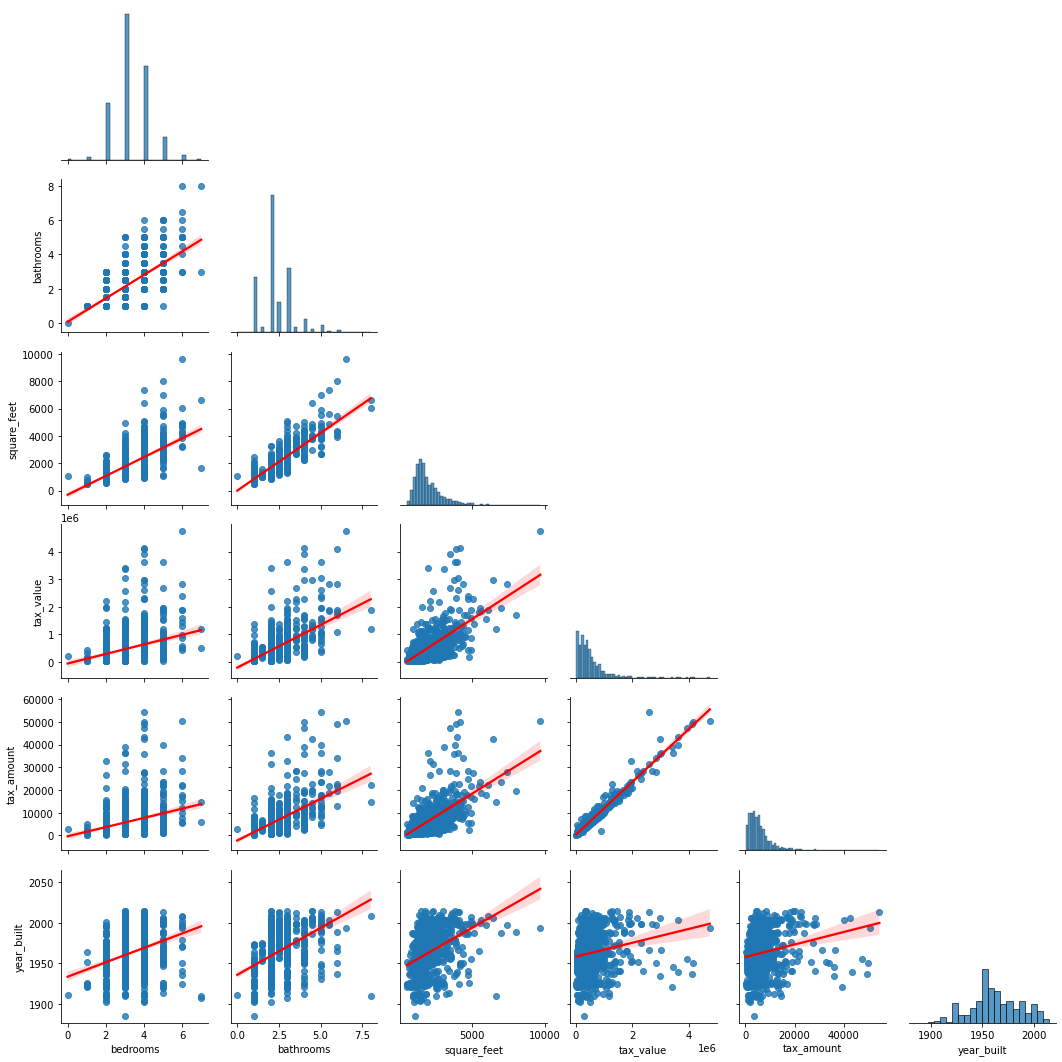

In [17]:
plot_variable_pairs(train[cont_cols].sample(1000))

In [18]:
df_corr = train.corr().reset_index()
corr_matrix = train.corr()
corr_matrix["tax_value"].sort_values(ascending=False).reset_index().style.background_gradient('coolwarm_r', vmin = -1, vmax = 1)

,index,tax_value
0,tax_value,1.000000
1,tax_amount,0.992834
2,square_feet,0.595221
3,bathrooms,0.517639
4,bedrooms,0.277379
5,year_built,0.167091
6,county_id,-0.051308


In [19]:
'''
# Create a Graph (countplot) to show data
plt.figure(figsize=(14,7))
 
# count plot on two categorical variable
sns.countplot(x ='internet_service_type', hue = "tax_value", data = train)

plt.title('Customer Churn by Internet Type', fontsize = 20)
plt.xlabel('Internet Type', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('# of Customers', fontsize = 16)

# Show the plot
plt.show()

'''

'\n# Create a Graph (countplot) to show data\nplt.figure(figsize=(14,7))\n \n# count plot on two categorical variable\nsns.countplot(x =\'internet_service_type\', hue = "tax_value", data = train)\n\nplt.title(\'Customer Churn by Internet Type\', fontsize = 20)\nplt.xlabel(\'Internet Type\', fontsize = 16)\nplt.xticks(fontsize = 14)\nplt.yticks(fontsize = 14)\nplt.ylabel(\'# of Customers\', fontsize = 16)\n\n# Show the plot\nplt.show()\n\n'

### EXPLORATION: Questions

Question 1: Do number of bathrooms impact tax value?

In [20]:
def visual(df, cont_col, cat_col):

    return sns.swarmplot(x=cat_col, y=cont_col, data=df)
    

In [21]:
# visual(train, 'tax_value', 'bedrooms')

#### EXPLORATION: Hypothesis Testing

## MODELING & EVALUATION

### Feature Engineering: K-Best

In [22]:
target = "tax_value"

# split train into X (dataframe, drop target) & y (series, keep target only)
X_train = train.drop(columns=[target])
y_train = train[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
X_validate = validate.drop(columns=[target])
y_validate = validate[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
X_test = test.drop(columns=[target])
y_test = test[target]

X_train.head()

,bedrooms,bathrooms,square_feet,year_built,tax_amount,geo_code,county_id
42782,2.0,1.0,614.0,1923,2863.70,6037.0,3101.0
40761,4.0,2.0,1792.0,1947,5673.98,6037.0,3101.0
2994,4.0,4.5,4052.0,2004,11679.74,6059.0,1286.0
35637,4.0,4.0,4342.0,1957,18950.81,6037.0,3101.0
16821,4.0,3.5,3238.0,1987,10355.22,6111.0,2061.0


In [23]:
X_train.shape

(29296, 7)

### Baseline

In [24]:
# establish a baseline for predicted tax value using median which is common for housing values
y_train['baseline'] = train.tax_value.median()
y_val['baseline'] = train.tax_value.median()

NameError: name 'y_val' is not defined

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

In [ ]:
type(X_train)

In [ ]:

# Make the filter
kbest = SelectKBest(f_regression, k=3)

# Fit the filter
kbest.fit(X_train.drop(columns = 'tax_amount'), y_train)

# Obtain results as a dataframe
kbest_results = pd.DataFrame(dict(p=kbest.pvalues_, f=kbest.scores_), index=X_train.drop(columns = 'tax_amount').columns)
kbest_results


In [ ]:
X_train.drop(columns = 'tax_amount').columns

In [ ]:
X_train_original = X_train.copy()
X_train = X_train.drop(columns='tax_amount')

In [ ]:
X_train_transformed = pd.DataFrame(
    kbest.transform(X_train),
    index=X_train.index,
    columns=X_train.columns[kbest.get_support()]
)
X_train_transformed.head().sort_index()

### Feature Engineering: RFE

In [ ]:
def scaled_data(X_train, X_validate, X_test, continuous_cols):

    scaler = sklearn.preprocessing.MinMaxScaler()

    # Fit the scaler, (fit the thing)
    scaler.fit(X_train[continuous_cols])

    # Use the scaler to transform train, validate, test (use the thing) and make them into dataframes
    X_train_scaled = pd.DataFrame(scaler.transform(X_train[continuous_cols]), index=X_train.index, columns=X_train[continuous_cols].columns)
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate[continuous_cols]), index=X_validate.index, columns=X_validate[continuous_cols].columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test[continuous_cols]), index=X_test.index, columns=X_test[continuous_cols].columns)
                                        
                                        
    
    return X_train_scaled, X_validate_scaled, X_test_scaled 

In [ ]:
X_train.shape, X_validate.shape, X_test.shape

In [ ]:
X_train_scaled, X_validate_scaled, X_test_scaled = scaled_data(X_train, X_validate, X_test,['bedrooms','bathrooms','square_feet', 'year_built'])


In [ ]:
X_train_scaled.head()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [ ]:
model = LinearRegression()
# Make the thing
rfe = RFE(model, n_features_to_select=2)
# Fit the thing
rfe.fit(X_train, y_train)
# Obtain results in dataframe
pd.DataFrame({'rfe_ranking': rfe.ranking_}, index=X_train.columns).sort_values(by = 'rfe_ranking')

In [ ]:
X_train.columns[rfe.get_support()]

## SIMPLE MODEL

In [ ]:
predictions = pd.DataFrame({
    'actual': validate.tax_value
}) 

In [ ]:
predictions.head()

In [ ]:
from sklearn.linear_model import LinearRegression

# X must be 2-d
X_train = train[['bathrooms']]
# y can be 1-d
y_train = train.tax_value

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train, y_train)
# 3. use the thing (make predictions)
X_validate = validate[['bathrooms']]
predictions['simple_lm'] = lm.predict(X_validate)

In [ ]:
predictions.head()

In [ ]:
lm.coef_, lm.intercept_

In [ ]:
print('tax_value = {:.3f} * bathrooms + {:.3f}'.format(lm.coef_[0], lm.intercept_))

In [ ]:
x_pred = np.array([0, 10]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

plt.figure(figsize=(16, 9))
plt.scatter(train.bathrooms, train.tax_value, label='actual')
plt.scatter(train.bathrooms, lm.predict(train[['bathrooms']]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='black', label='linear model prediction line')


plt.xlabel('Bathrooms')
plt.ylabel('Tax Value')
plt.legend()

In [ ]:
Turn continuous into categorical example houses greater than or less than (square feet).